<a href="https://colab.research.google.com/github/shivam-kotwalia/data-science-project/blob/master/Image_Segmentation_on_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Segmetation on Oxford Pets Dataset 

In [0]:
# Download the dataset 
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvf images.tar.gz
!tar -xvf annotations.tar.gz

In [3]:
import os
import numpy as np 
import pandas as pd
import PIL
# print(os.getcwd())
print(len(os.listdir("images")))
images_name = os.listdir("images")
images_name = [i.split("_")[0] for i in images_name]
print(images_name[0])
print(pd.Series(images_name).value_counts())

7393
havanese
american         400
english          400
Abyssinian       203
Russian          200
german           200
Egyptian         200
basset           200
leonberger       200
great            200
British          200
Siamese          200
chihuahua        200
samoyed          200
pug              200
Birman           200
Persian          200
newfoundland     200
Bombay           200
Sphynx           200
shiba            200
boxer            200
Ragdoll          200
japanese         200
havanese         200
miniature        200
beagle           200
Bengal           200
wheaten          200
yorkshire        200
pomeranian       200
saint            200
keeshond         200
Maine            200
scottish         199
staffordshire    191
dtype: int64


In [4]:
os.listdir("annotations/trimaps/")[:5]

['Persian_46.png',
 '._Birman_119.png',
 'chihuahua_131.png',
 'shiba_inu_141.png',
 '._wheaten_terrier_128.png']

In [5]:
"Persian_46"

'Persian_46'

Original Image Shape -  (375, 500, 3)


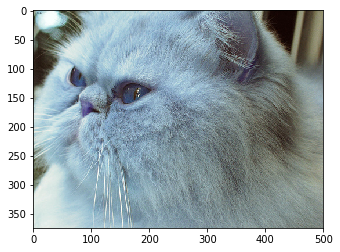

Masked Image Shape -  (375, 500, 3)


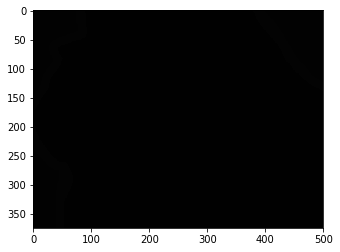

In [6]:
import cv2
import matplotlib.pyplot as plt
original_image = cv2.imread("images/Persian_46.jpg")
masked_image = cv2.imread("annotations/trimaps/Persian_46.png")

plt.imshow(original_image)
print("Original Image Shape - ", original_image.shape)
plt.show()

plt.imshow(masked_image, cmap="gray")
print("Masked Image Shape - ", masked_image.shape)
plt.show()

In [7]:
masked_image.max(), masked_image.min(), np.unique(masked_image)

(3, 1, array([1, 2, 3], dtype=uint8))

Masked Image Shape -  (375, 500, 3)


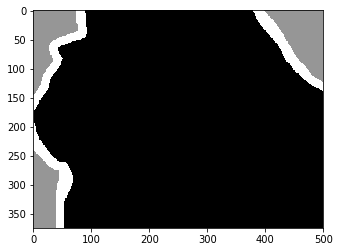

In [8]:
# Masked images have only 3 pixels 1,2,3 so it cant be plotted, we need to
# differentiate them broadly 
masked_image = np.where(masked_image == 2, 150, masked_image)
masked_image = np.where(masked_image == 1, 0, masked_image)
masked_image = np.where(masked_image == 3, 255, masked_image)
plt.imshow(masked_image, cmap="gray")
print("Masked Image Shape - ", masked_image.shape)
plt.show()

In [0]:
# Getting all images
import os
input_dir = 'images/'
target_dir = 'annotations/trimaps/'
img_size = (160, 160)
num_classes = 4
batch_size = 32

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith('.jpg')])
target_img_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith('.png') and not fname.startswith('.')])

In [10]:
print('Number of samples:', len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:5], target_img_paths[:5]):
  print(input_path, '|', target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png


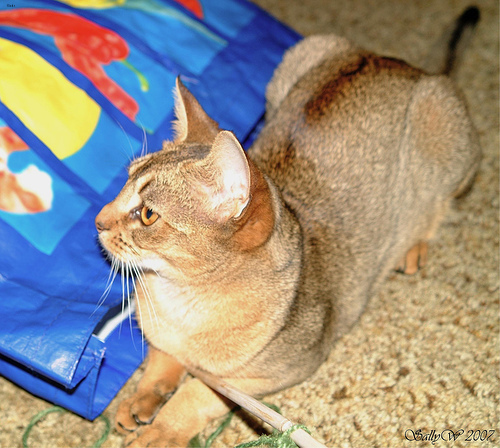

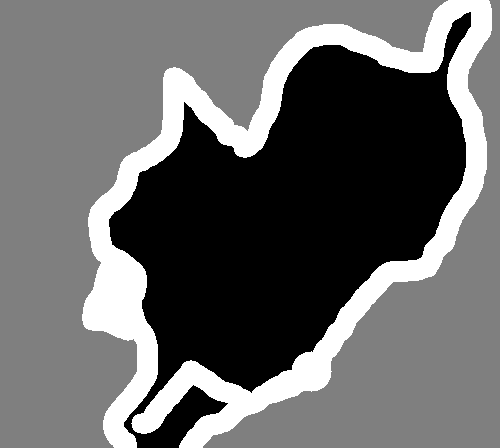

In [11]:
# Read the auto contrast function from PIL 
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[9]))

# Display auto-constrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

### Sequence Class to load the data in batches & vectorize the data

In [0]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i: i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i: i + self.batch_size]
        x = np.zeros((batch_size,) + self.img_size + (3,), dtype='float32')
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((batch_size,) + self.img_size + (1,), dtype='uint8')
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size,
                           color_mode='grayscale')
            y[j] = np.expand_dims(img, 2)
        return x, y
# This will return the x(original images) and y (masked images) in bacthes
# of desireded batch_size 

## Perpare U-Net Xception-style model

In [0]:
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

        # Project residual
        residual = layers.Conv2D(
            filters, 1, strides=2, padding='same')(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    previous_block_activation = x  # Set aside residual

    for filters in [256, 128, 64, 32]:
        x = layers.Activation('relu')(x)
        x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation('relu')(x)
        x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding='same')(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual
    
    # Add a per-pixel classification layer
    outputs = layers.Conv2D(
        num_classes, 3, activation='sigmoid', padding='same')(x)
    
    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [0]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

In [27]:
# Build model
# img_size = 160, 160 
# num class = 4
model = get_model(img_size, num_classes)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization_v1[0][0]     
__________________________________________________________________________________________________
activation

### Train Test Split

In [0]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(batch_size, img_size,
                       train_input_img_paths, train_target_img_paths)
val_gen = OxfordPets(batch_size, img_size,
                     val_input_img_paths, val_target_img_paths)

### Train the model 

In [0]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

callbacks = [
    keras.callbacks.ModelCheckpoint('oxford_segmentation.h5',
                                    save_best_only=True)
]

# Train the model, doing validation at the end of each epoch
model.fit(train_gen, epochs=50, validation_data=val_gen, callbacks=callbacks)

Epoch 1/50
199/199 [==============================] - 93s 467ms/step - loss: 5.9477 - val_loss: 13.1467
Epoch 2/50
199/199 [==============================] - 88s 442ms/step - loss: 5.5921 - val_loss: 13.6898
Epoch 3/50
199/199 [==============================] - 88s 441ms/step - loss: 5.3702 - val_loss: 15.5381
Epoch 4/50
199/199 [==============================] - 88s 443ms/step - loss: 5.1999 - val_loss: 13.9948
Epoch 5/50
199/199 [==============================] - 88s 443ms/step - loss: 5.0241 - val_loss: 13.9881
Epoch 6/50
199/199 [==============================] - 88s 442ms/step - loss: 4.8707 - val_loss: 15.7312
Epoch 7/50
199/199 [==============================] - 88s 444ms/step - loss: 4.7359 - val_loss: 14.8236
Epoch 8/50
199/199 [==============================] - 88s 444ms/step - loss: 4.5689 - val_loss: 13.9381
Epoch 9/50
199/199 [==============================] - 88s 441ms/step - loss: 4.4231 - val_loss: 15.1744
Epoch 10/50
199/199 [==============================] - 88s 441ms

In [18]:
model

In [0]:
# Validation Batch
# Generate predictions for all images in the validation set

val_gen = OxfordPets(batch_size, img_size,
                     val_input_img_paths, val_target_img_paths)

In [0]:
val_preds = model.predict(val_gen)

In [30]:
val_preds[0].shape

(160, 160, 4)

In [31]:
np.argmax(val_preds[0], axis=-1).shape

(160, 160)

In [32]:
np.expand_dims(np.argmax(val_preds[0], axis=-1), axis=-1).shape

(160, 160, 1)

In [0]:
def display_mask(i):
  """Quick utility to display a model's prediction."""
  mask = np.argmax(val_preds[i], axis=-1)
  mask = np.expand_dims(mask, axis=-1)
  img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
  display(img)

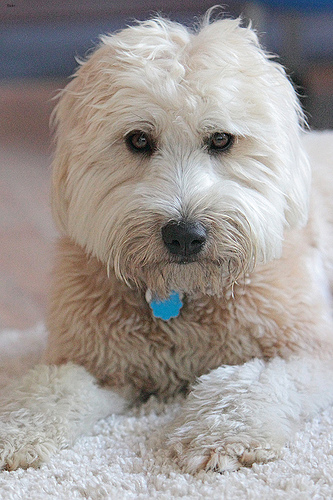

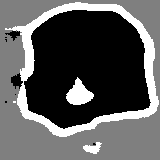

In [46]:
from IPython.display import display

display(PIL.Image.open(val_input_img_paths[70]))

display_mask(70)